In [30]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
import math
from os import listdir
import data_visualization as dv
import pickle
import scipy 
from scipy.stats import norm
from scipy import stats
from tqdm import tqdm 
import random
wheel = dv.ColorWheel()

In [31]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.style.use('cashaback_dark')

#%% Plot properties
box_lw = 2.5 #box linewidth
boxwidth = .07 #box width
whisker_lw = 2.0 #whisker linewidth
circle_size = 8 

tp3_title = "1000,50"
tp4_title = "1000,150"
tp5_title = '1100,50'
tp6_title = "1100,150"
tp7_title = "1200,50"
tp8_title = '1200,150'
tp9_title = '1300,100'
tp10_title = '1300,200'
trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title, tp7_title, tp8_title]

box_color1 = wheel.seth_red
box_color2 = wheel.seth_blue
box_color3 = '0.4'
#boxprops
two_props = {"facecolor": "none", "edgecolor" : box_color1, "linewidth": box_lw, "alpha": 1}
three_props = {"facecolor": "none", "edgecolor" : box_color2, "linewidth": box_lw, "alpha": 1}
four_props = {"facecolor": "none", "edgecolor" : box_color3, "linewidth": box_lw, "alpha": 1}
#whiskerprops
two_whisk = {"linewidth" : whisker_lw, "color": box_color1}
three_whisk = {"linewidth" : whisker_lw, "color": box_color2}
four_whisk = {"linewidth" : whisker_lw, "color": box_color3}
#capprops
two_cap = {"linewidth" : whisker_lw, "color": box_color1}
three_cap = {"linewidth" : whisker_lw, "color": box_color2}
four_cap = {"linewidth" : whisker_lw, "color": box_color3}
#medianprops
two_median = {"linewidth" : whisker_lw, "color": box_color1}     
three_median = {"linewidth" : whisker_lw, "color": box_color2}   
four_median = {"linewidth" : whisker_lw, "color": box_color3}        
    
#total_indecisions = np.concatenate((perc_player_indecisions,perc_indecisions_R))
props = [{}, {}, {}, {}, {}, {}]
props_dict = {}
box_color = 'grey'
dot_color = 'black'   

In [32]:
# Initial thangs
os.chdir('D:\\Subject_Data\\Seth_MatchPennies_Agent_Pilot_v3')
PATH = os.getcwd()
save_path = '\\Figures\\'
if not os.path.exists(PATH+save_path):
        os.makedirs(PATH+save_path)

with open(PATH+"\\Analysis_Pull_List.txt","r") as pull_file:
    analysis_pull_list = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt","r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()  
# SPECIFIC TO EXPERIMENT   
reaction_trials = 50    
timing_trials = 50
num_trials = 100 #number of trials in each block 
num_blocks = 6
tot_trials = num_trials*num_blocks
data_columns = len(fields_pull)
trial_time = 1500
num_subjects = len(analysis_pull_list)
wheel = dv.ColorWheel()

plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

### Functions

In [33]:
#%% Box plot with option to make double boxplot
def boxplot(data, xlocs, ylocs, box_widths = 0.15, shift_box = False, shift_direction = 1, 
            legend_labels = None, xlab = None, ylab=None, title=None):
    og_xlocs = xlocs
    box_xlocs = xlocs
    props = [two_props,two_whisk,two_cap,two_median]
    if shift_box:
        box_xlocs = box_xlocs + shift_direction*box_widths*4
        xlocs = xlocs + shift_direction*box_widths*4
        if shift_direction == 1:
            props = [three_props,three_whisk,three_cap,three_median]
        else:
            props = [two_props,two_whisk,two_cap,two_median]

    filtered_data = data
    if np.isnan(data).any():
        mask = ~np.isnan(data)
        filtered_data = [d[m] for d,m in zip(data.T, mask.T)]
    else:
        filtered_data = data
    ax.patch.set_alpha(0.05)
    markercolor = ['orange','r','g','b','black',wheel.dark_blue]
    ax.boxplot(filtered_data, positions=box_xlocs, patch_artist=True, boxprops = props[0], whiskerprops = props[1], 
                capprops = props[2], medianprops = props[3], showfliers=False, widths = (box_widths)*len(xlocs))
    ax.set_xticks(og_xlocs) 
    #ax.set_xticklabels(trial_block_titles)
    ax.set_yticks(ylocs)
    ax.set_yticklabels(ylocs) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    if shift_box:
        colors = [wheel.seth_red, wheel.seth_blue]
        dv.Custom_Legend(ax, legend_labels, colors, fontsize = 12)


### Pickle

In [34]:
trial_table = np.empty((num_subjects, tot_trials, 4), int)
player_reach_time = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 
player_decision_array = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 
reaction_time = np.zeros([num_subjects,reaction_trials])*np.nan 
reaction_movement_time = np.zeros([num_subjects,reaction_trials])*np.nan 
rt_trial_start = np.zeros((num_subjects,reaction_trials))*np.nan 
timing_reach_time = np.zeros([num_subjects,reaction_trials])*np.nan 
hand_pos_data = np.zeros((num_subjects, num_blocks, num_trials, trial_time+500, 4))*np.nan
agent_decision_time = np.zeros((num_subjects,num_blocks,num_trials))
agent_target_selection = np.zeros((num_subjects,num_blocks,num_trials))
player_decision_time = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 
for i in range(num_subjects):
    subname = analysis_pull_list[i]
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    #trial_table[i,:,:] = pickle.load(open(data_path + f'{subname}_trial_table.pkl', 'rb'))
    hand_pos_data[i,:,:,:,:] = pickle.load(open(data_path+f'{subname}_hand_pos_data.pkl', 'rb'))
    reaction_time[i,:] = pickle.load(open(data_path + f'{subname}_reaction_time.pkl', 'rb'))
    reaction_movement_time[i,:] = pickle.load(open(data_path + f'{subname}_reaction_movement_time.pkl', 'rb'))
    rt_trial_start[i,:] = pickle.load(open(data_path + f'{subname}_rt_trial_start.pkl', 'rb'))
    agent_decision_time[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_decision_time.pkl', 'rb'))
    agent_target_selection[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_target_selection.pkl', 'rb'))
    player_reach_time[i,:,:] = pickle.load(open(data_path + f'{subname}_player_reach_time.pkl', 'rb'))
    player_decision_time[i,:,:] = pickle.load(open(data_path + f'{subname}_player_decision_time.pkl', 'rb'))
    player_decision_array[i,:] = pickle.load(open(data_path + f'{subname}_player_decision_array.pkl', 'rb'))
    timing_reach_time[i,:] = pickle.load(open(data_path + f'{subname}_timing_reach_time.pkl', 'rb'))


Calculate wins, indecisions, incorrects (w/ only first 80 trials)

In [35]:
# Win, Loss, Indecision counts
# Make sure agent_target_selection replaces 2 with -1 from the first pilot
agent_target_selection = np.where(agent_target_selection ==2,-1,agent_target_selection)
player_indecisions = np.zeros((num_subjects, num_blocks))
player_wins = np.zeros((num_subjects, num_blocks))
player_incorrect_decisions = np.zeros((num_subjects,num_blocks))
n = 80
num_trials = n # Set number of trials to 80
for i in range(num_subjects):
    for j in range(num_blocks):
        player_indecisions[i,j] = np.count_nonzero(player_decision_array[i,j,:n] == 0)
        player_wins[i,j] = np.count_nonzero(np.logical_and(player_decision_array[i,j,:n] == 1 , agent_target_selection[i,j,:n] == 1))
        player_wins[i,j]+= np.count_nonzero(np.logical_and(player_decision_array[i,j,:n] == -1 , agent_target_selection[i,j,:n] == -1))
        player_wins[i,j]+= np.count_nonzero(np.logical_and(player_decision_array[i,j,:n] == -1 , agent_target_selection[i,j,:n] == 0))
        player_wins[i,j]+= np.count_nonzero(np.logical_and(player_decision_array[i,j,:n] == 1 , agent_target_selection[i,j,:n] == 0))
        player_incorrect_decisions[i,j] = np.count_nonzero(np.logical_and(player_decision_array[i,j,:n] == 1 , agent_target_selection[i,j,:n] == -1))
        player_incorrect_decisions[i,j] += np.count_nonzero(np.logical_and(player_decision_array[i,j,:n] == -1 , agent_target_selection[i,j,:n] == 1))
perc_player_indecisions = (player_indecisions / num_trials)*100
perc_player_wins = (player_wins / num_trials)*100
perc_player_incorrect_decisions = (player_incorrect_decisions/num_trials)*100

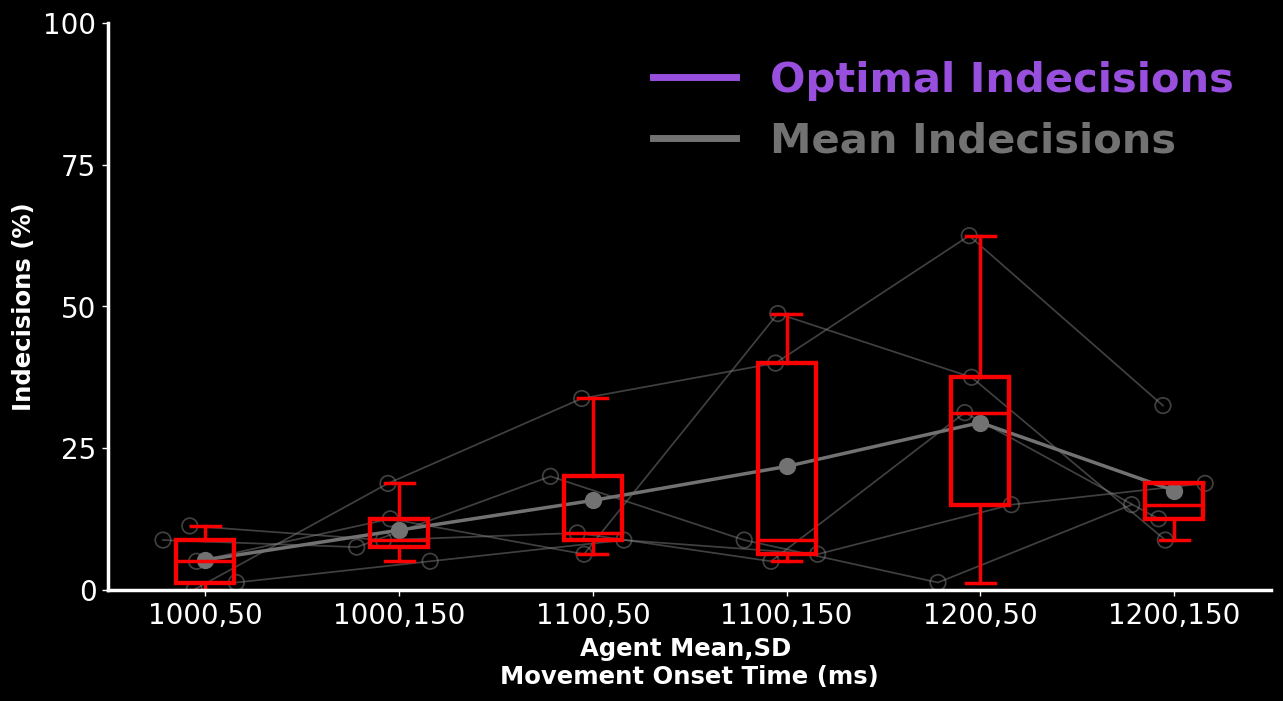

In [36]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
stored_optimal_indecisions = [0.06,12.07,8.5,13.84,0.3,6.24]

plt.figure(dpi=125, figsize=(12,6))
ax=plt.subplot()
boxplot(perc_player_indecisions, box_widths = 0.05, xlocs=xlocs, ylocs=ylocs, xlab = "Agent Mean,SD \nMovement Onset Time (ms)",
       ylab='Indecisions (%)', title=None)
#ax.plot(jitter(xlocs, perc_player_indecisions).T,perc_player_indecisions.T, marker = 'o',markerfacecolor = dot_color, markeredgecolor = '0.6', color='0.3', alpha = 0.8,zorder=1 )
dv.jitter_array(ax,xlocs,perc_player_indecisions.T,0.1, circle_size = 80, circle_lw = 1,lw = 1, circle_alpha = 0.5, include_mean = True )
#ax.scatter(xlocs,stored_optimal_indecisions, marker = 's', s = 100,c=wheel.purple, zorder = 20)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
dv.Custom_Legend(ax,['Optimal Indecisions','Mean Indecisions'],[wheel.purple,wheel.dark_grey], fontsize = 24)
#plt.savefig(PATH+save_path+'indecision_boxplots', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

In [37]:
perc_player_indecisions

array([[ 5.  , 12.5 ,  6.25, 48.75, 37.5 ,  8.75],
       [11.25,  8.75, 10.  ,  5.  , 31.25, 12.5 ],
       [ 8.75,  7.5 , 20.  ,  8.75,  1.25, 15.  ],
       [ 1.25,  5.  ,  8.75,  6.25, 15.  , 18.75],
       [ 0.  , 18.75, 33.75, 40.  , 62.5 , 32.5 ]])

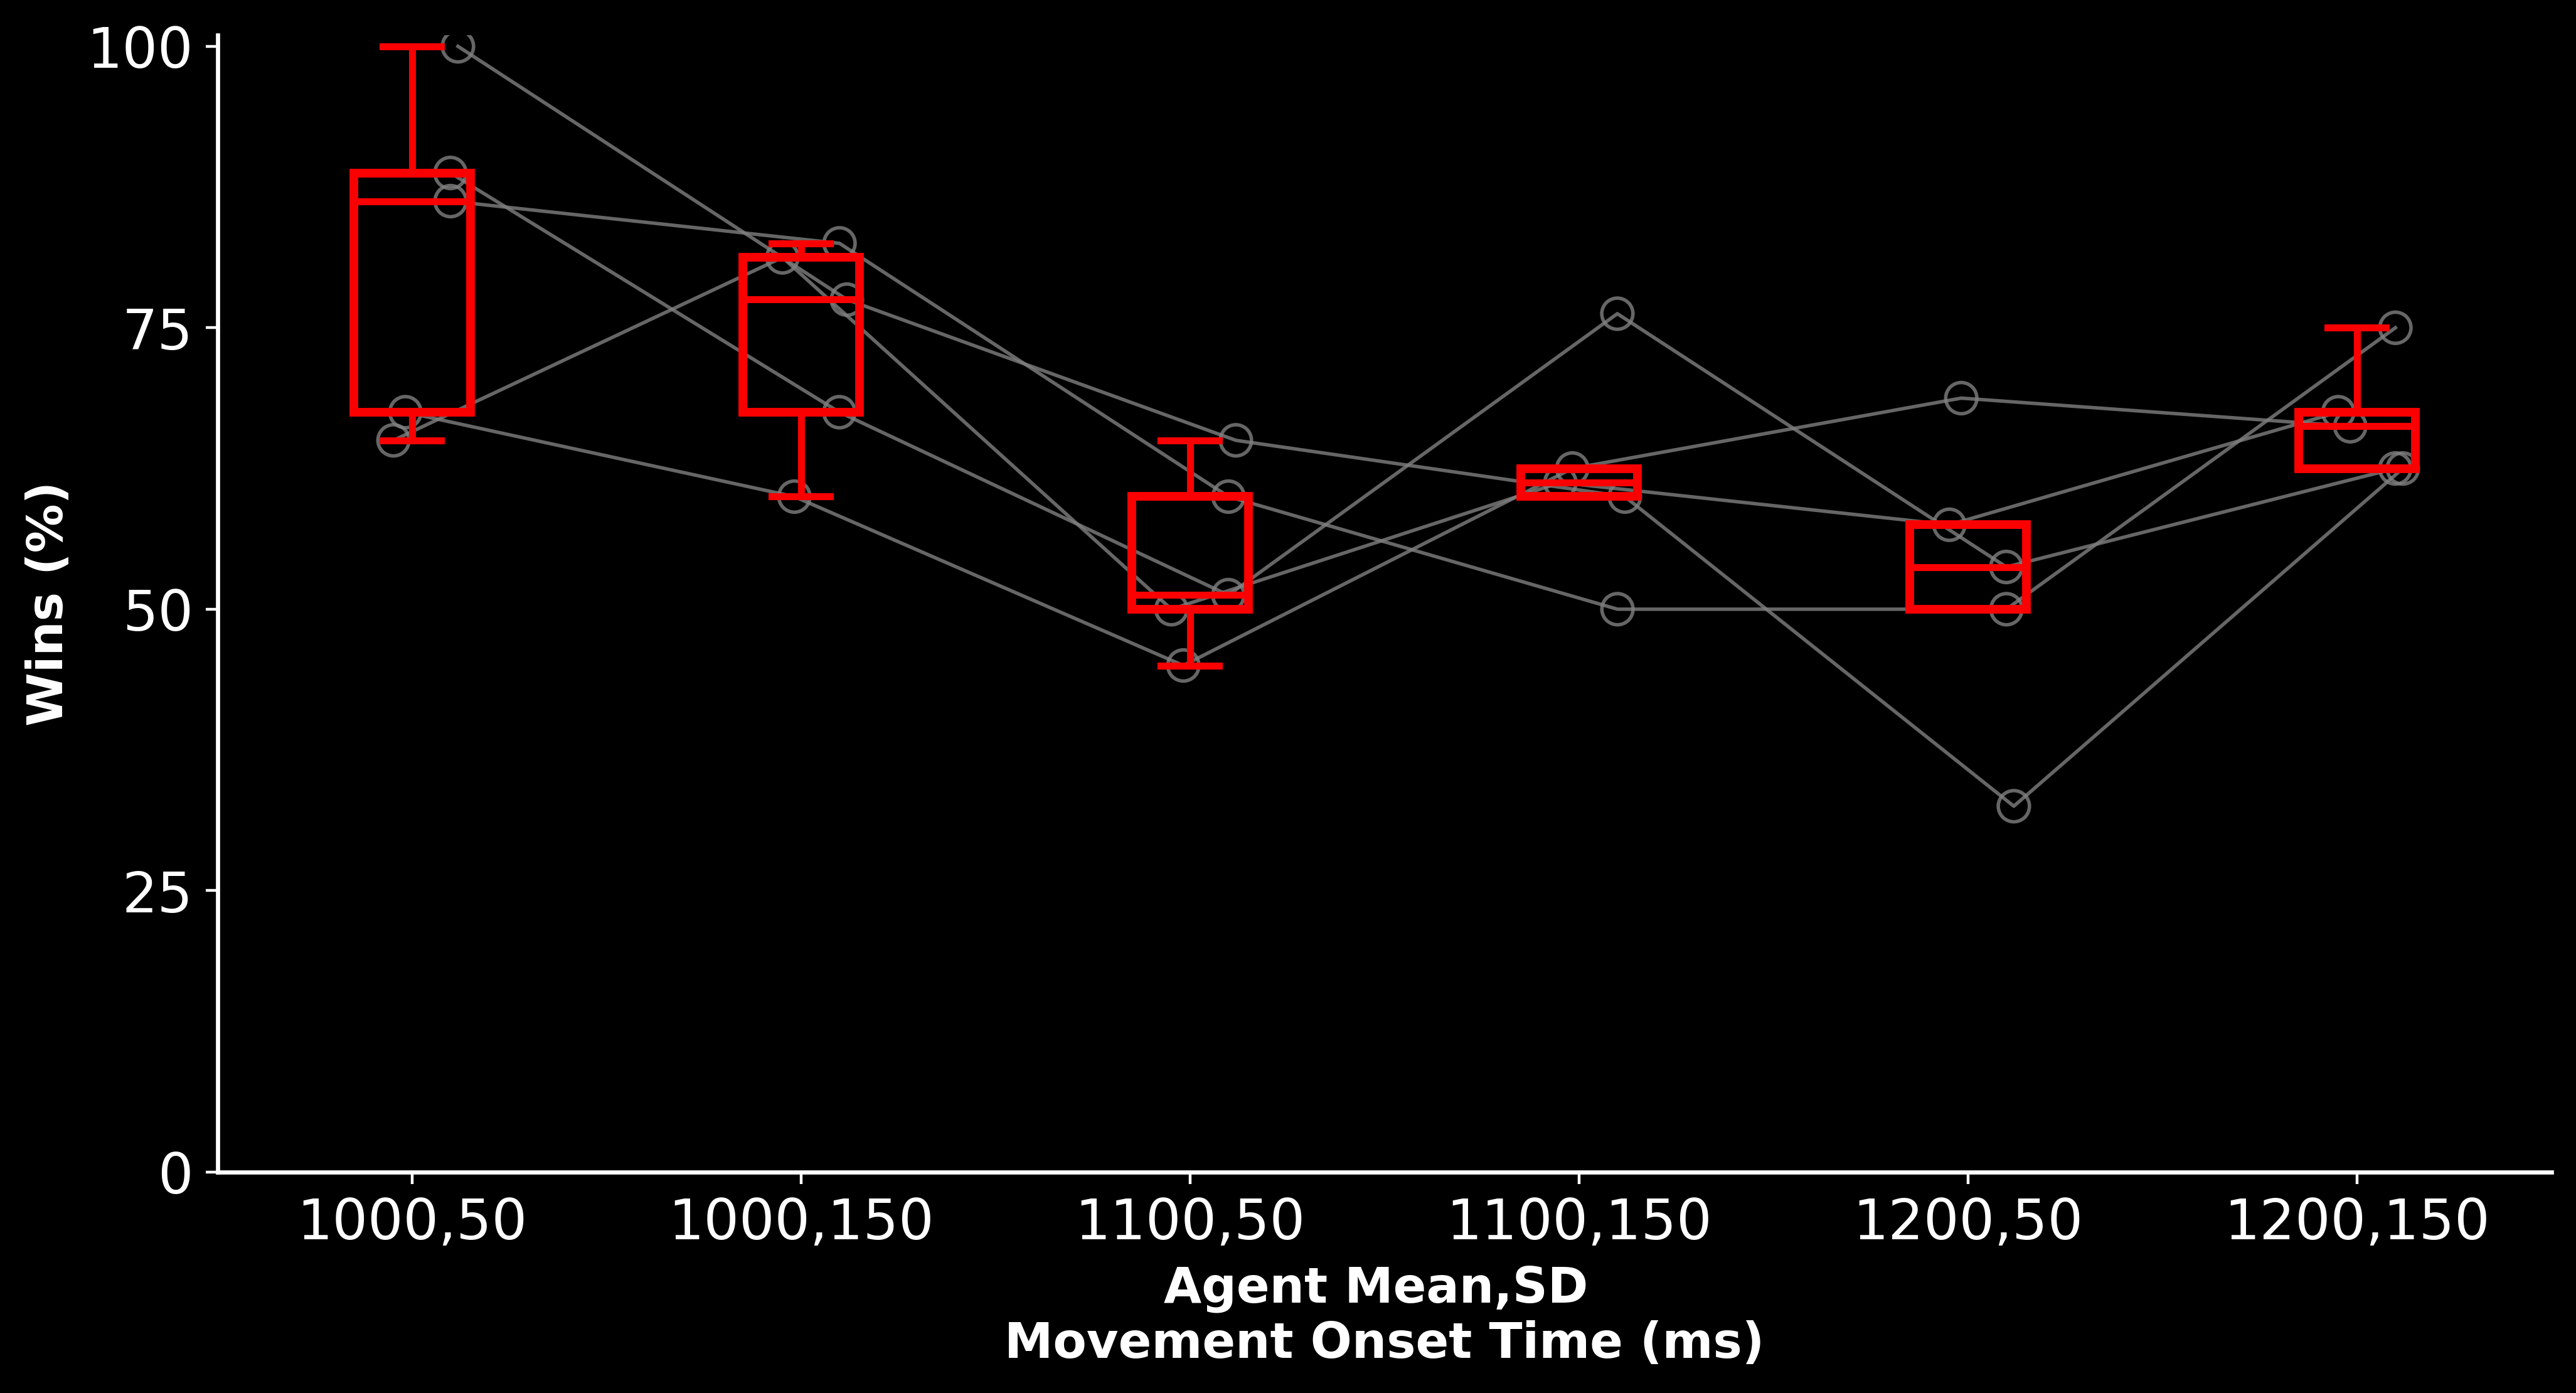

In [38]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
plt.figure(dpi=400, figsize=(12,6))
ax=plt.subplot()
boxplot(perc_player_wins, box_widths = 0.05, xlocs=xlocs, ylocs=ylocs, xlab = "Agent Mean,SD \nMovement Onset Time (ms)",
        ylab='Wins (%)', title=None)
#ax.plot(jitter(xlocs, perc_player_indecisions).T,perc_player_indecisions.T, marker = 'o',markerfacecolor = dot_color, markeredgecolor = '0.6', color='0.3', alpha = 0.8,zorder=1 )
dv.jitter_array(ax,xlocs,perc_player_wins.T,0.1, circle_size = 80, circle_lw = 1,lw = 1, circle_alpha = 0.8, include_mean = False, )
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,101)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
#plt.savefig(PATH+save_path+'indecision_boxplots', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

In [39]:
perc_player_wins

array([[ 86.25,  82.5 ,  60.  ,  50.  ,  50.  ,  75.  ],
       [ 88.75,  67.5 ,  51.25,  76.25,  53.75,  62.5 ],
       [ 67.5 ,  60.  ,  45.  ,  62.5 ,  68.75,  66.25],
       [ 65.  ,  81.25,  50.  ,  61.25,  57.5 ,  67.5 ],
       [100.  ,  77.5 ,  65.  ,  60.  ,  32.5 ,  62.5 ]])

In [40]:
80*6 + 25*6 + 300

930